# Covnet- LSTM Classifier

In [15]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import SpatialDropout1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Input, Concatenate
from keras.layers.wrappers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
output_dir = '/Users/trinakarmakar/anaconda2/model_output/MultiCNN/'

#training hyperparameters
epochs = 4
batch_size = 128

#vector space embedding hyper parameters 
n_dim = 64 
n_unique_words = 10000
max_review_length = 100
pad_type = trunc_type = 'pre' #pad shorter reviews or truncate longer reviews 
drop_emb = 0.2

n_conv_1 = n_conv_2 = n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

mp_size = 4

n_dense = 256
drop_dense = 0.2

In [4]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [6]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)

In [17]:
input_layer = Input(shape=(max_review_length,), dtype='int16', name = 'input')
embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_emb, name='drop_emb')(embedding_layer)
conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)


dense_layer = Dense(n_dense, activation='relu', name='dense')(maxp_1)
drop_dense_layer = Dropout(drop_dense, name='drop_dense')(dense_layer)

predictions = Dense(1, activation='sigmoid', name='output')(drop_dense_layer)

model = Model(input_layer, predictions)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
drop_emb (SpatialDropout1D)  (None, 100, 64)           0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 98, 256)           49408     
_________________________________________________________________
maxp_1 (GlobalMaxPooling1D)  (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
drop_dense (Dropout)         (None, 256)               0         
__________

In [22]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"weights.{epoch:02d}.hdf5")

In [24]:
model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, verbose=1, validation_data=(X_valid, y_valid), 
          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 219s 9ms/step - loss: 0.5206 - acc: 0.7168 - val_loss: 0.3490 - val_acc: 0.8437

In [25]:
model.load_weights(output_dir+'weights.01.hdf5')

In [27]:
y_hat = model.predict(X_valid)

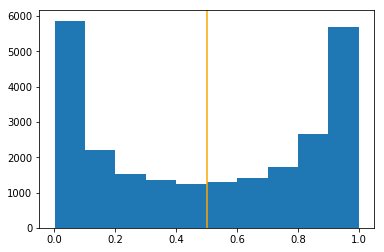

In [28]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [29]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [30]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.53'

In [31]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=["y_hat", 'y'])

In [32]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10) #predicted highly negative but in reality it is postive review

,y_hat,y
256,0.956760,0
299,0.921546,0
310,0.933011,0
328,0.949527,0
624,0.902837,0
693,0.954810,0
710,0.912603,0
740,0.958345,0
810,0.915792,0
872,0.901999,0


In [33]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10) #predicted positive but in reality it is negative review

,y_hat,y
101,0.035767,1
146,0.094877,1
325,0.046664,1
345,0.060811,1
763,0.064735,1
1113,0.093943,1
1229,0.076638,1
1255,0.017266,1
1384,0.052873,1
1710,0.056925,1
